In [326]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
from imblearn.over_sampling import SMOTE, SMOTENC

import warnings
warnings.filterwarnings("ignore")

In [481]:
#загрузим данные
data_train = pd.read_excel("Data/data_train.xls")
data_test = pd.read_excel("Data/data_test.xls")
print(data_train.info())

#проведём разведочный анализ
#profile = ProfileReport(data_train, title = "Data Stats")
#profile.to_file("DataReport.html")

#fig = px.histogram(x = data_train['СОБСТВЕННИК_ФАКТ.'])
#fig.show()

#исправим выброс
data_train.loc[data_train['СУММА_ВЫДАННОГО_КРЕДИТА'] == max(data_train['СУММА_ВЫДАННОГО_КРЕДИТА']),\
               'СУММА_ВЫДАННОГО_КРЕДИТА'] = 70000

data_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6010 entries, 0 to 6009
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ИД                           6010 non-null   int64  
 1   ВОЗРАСТ                      6010 non-null   float64
 2   ВОЗРАСТ.ЛЕТ                  6010 non-null   int64  
 3   ПОЛ                          6010 non-null   int64  
 4   СМЕНА_МЖ                     6010 non-null   int64  
 5   ЗАГРАН                       6010 non-null   int64  
 6   БРАК                         6010 non-null   int64  
 7   ДЕТИ                         6010 non-null   int64  
 8   ИЖДИВЕНЦЫ                    6010 non-null   int64  
 9   ОБРАЗОВАНИЕ                  6010 non-null   int64  
 10  ИНОСТР.ЯЗЫК                  6010 non-null   int64  
 11  АВТО                         6010 non-null   int64  
 12  ОТРАСЛЬ                      6010 non-null   int64  
 13  РАБОТА_ПО_НАПР    

ИД    ВОЗРАСТ  ВОЗРАСТ.ЛЕТ  ПОЛ  СМЕНА_МЖ  ЗАГРАН  БРАК  ДЕТИ  ИЖДИВЕНЦЫ  \
0  6047  34.942466           35    2         0       0     2     2          2   
1  6048  34.476712           34    2         0       0     1     2          2   
2  6049  35.843836           36    2         0       0     4     2          2   
3  6050  26.383562           26    2         0       0     1     1          1   
4  6051  43.950685           44    2         0       0     3     3          3   

   ОБРАЗОВАНИЕ  ...  СУММА_ВЫДАННОГО_КРЕДИТА  ОТДЕЛЕНИЕ  ГОРОД  \
0            2  ...                    20000         73     10   
1            2  ...                    15000         79     12   
2            2  ...                    30000        153     10   
3            3  ...                    20000        115      1   
4            2  ...                    13000        227     27   

   ЗАПРОШЕННАЯ_СУММА  СОБСТВЕННИК_ФАКТ.  ДОХОД_СУПРУГИ(А)  КРЕДИТЫ_ПОГАШЕНЫ  \
0              20000                  5             20000                 0   
1              15000                  2              8000                 0   
2              30000                  1                 0                 1   
3              20000                  5             18000                 0   
4              13000                  5                 0                 0   

   ПЕРВЫЙ_КРЕДИТ  ДЕФОЛТ60 (Прогноз)  Скоринговый балл  
0              0                 NaN               NaN  
1              1                 NaN               NaN  
2              0                 NaN               NaN  
3              1                 NaN               NaN  
4              1                 NaN               NaN  

[5 rows x 29 columns]

In [522]:
#подготовка данных
def PrepareData(df):
    #сначала уберём столбцы, которые точно не будем использовать
    tmp_df = df.drop(columns = ['ИД', 'ВОЗРАСТ.ЛЕТ', 'ЗАГРАН', 'ОТДЕЛЕНИЕ',\
                                'СМЕНА_МЖ', 'АВТО'])
    
    #исходя из распределения некоторых категориальных признаков, преобразуем соответствующие столбцы
    #tmp_df['АВТО'] = [val if val == 0 else 1 for val in list(tmp_df['АВТО'])]
    
    cities = [1, 9, 10, 15, 22, 27]
    tmp_df['ГОРОД'] = [val if val in cities else 0 for val in list(tmp_df['ГОРОД'])]
    
    tmp_df['ДОЛЖНОСТЬ'] = [1 if val == 5 else 0 for val in list(tmp_df['ДОЛЖНОСТЬ'])]
    
    tmp_df['ДОХОД_СУПРУГИ(А)_ФЛАГ'] = [0 if val == 0 else 1 for val in list(tmp_df['ДОХОД_СУПРУГИ(А)'])]
    
    tmp_df['ИНОСТР.ЯЗЫК'] = [1 if val == 4 else 0 for val in list(tmp_df['ИНОСТР.ЯЗЫК'])]
    
    tmp_df['ИЖДИВЕНЦЫ'] = [0 if val == 0 else 1 for val in list(tmp_df['ИЖДИВЕНЦЫ'])]
    
    tmp_df['ОБРАЗОВАНИЕ'] = [1 if val == 2 else 0 for val in list(tmp_df['ОБРАЗОВАНИЕ'])]
    
    field = [1, 7, 14, 32, 37]
    tmp_df['ОТРАСЛЬ'] = [val if val in cities else 0 for val in list(tmp_df['ОТРАСЛЬ'])]
    
    tmp_df['ПОЛ'] = tmp_df['ПОЛ'].replace({2: 0})
    
    ohe_features = ['ГОРОД', 'ОТРАСЛЬ', 'РАБОТА_В_ОРГ', 'РАБОТА_ПО_НАПР']
    for feature in ohe_features:
        tmp_df = pd.concat([tmp_df, pd.get_dummies(tmp_df[feature], prefix = feature)], axis = 1)
        
    #займёмся feature engineering
    tmp_df['СУПРУГ_ПОЛ_ДОХОД'] = (1 - tmp_df['ПОЛ'])*tmp_df['ДОХОД_СУПРУГИ(А)_ФЛАГ']
    tmp_df['ЗАПРОС_ВЫДАЛИ_РАЗНИЦА'] = tmp_df['ЗАПРОШЕННАЯ_СУММА'] - tmp_df['СУММА_ВЫДАННОГО_КРЕДИТА']
    tmp_df['КРЕДИТ_ЗАРПЛАТА_ОТНОШЕНИЕ'] = tmp_df['ПЕРСОНАЛЬНЫЙ_ДОХОД']/tmp_df['СУММА_ВЫДАННОГО_КРЕДИТА']
    tmp_df['КРЕДИТ_ДОХОД_ОТНОШЕНИЕ'] = tmp_df['ДОХОД_СЕМЬИ_']/tmp_df['СУММА_ВЫДАННОГО_КРЕДИТА']
    tmp_df['КРЕДИТ_ДОХОД_1_ОТНОШЕНИЕ'] = tmp_df['ДОХОД_НА_ОДНОГО_ЧЛЕНА_СЕМЬИ']/tmp_df['СУММА_ВЫДАННОГО_КРЕДИТА']
    #tmp_df['КРЕДИТ_ЗАРПЛАТА_СУПРУГА_ОТНОШЕНИЕ'] = tmp_df['ДОХОД_СУПРУГИ(А)']/tmp_df['СУММА_ВЫДАННОГО_КРЕДИТА']
        
    tmp_df = tmp_df.drop(columns = ohe_features + ['ЗАПРОШЕННАЯ_СУММА'])
    return tmp_df

In [523]:
data_train_processed = PrepareData(data_train)
data_test_processed = PrepareData(data_test).drop(columns = ['РАБОТА_ПО_НАПР_0'])

#необходимо отмасштабировать численные признаки, например, применив Standard Scaler
#Напишем его сами, чтобы мат. ожидание и дисперсию каждого признака в обучающей выборке использовать и при
#подготовке тестововой выборки (обучающу выборку будем считать генеральной совокупностью, то есть положим,
#что из неё можно получить почти истинные значения мат. ожиданий и дисперсий)
numerical_features = ['БРАК', 'ВОЗРАСТ', 'ДЕТИ', 'ДОХОД_НА_ОДНОГО_ЧЛЕНА_СЕМЬИ', 'ДОХОД_СЕМЬИ_',\
                      'СУММА_ВЫДАННОГО_КРЕДИТА', 'ПЕРСОНАЛЬНЫЙ_ДОХОД', 'СОБСТВЕННИК_ФАКТ.',\
                      'ДОХОД_СУПРУГИ(А)', 'ЗАПРОС_ВЫДАЛИ_РАЗНИЦА', 'КРЕДИТ_ЗАРПЛАТА_ОТНОШЕНИЕ',\
                      'КРЕДИТ_ДОХОД_ОТНОШЕНИЕ', 'КРЕДИТ_ДОХОД_1_ОТНОШЕНИЕ']
categorical_features_train = [val for val in list(data_train_processed.columns) if val not in numerical_features]
categorical_features_test = [val for val in list(data_test_processed.columns) if val not in numerical_features]

data_train_processed = pd.concat([
    pd.DataFrame(data = data_train_processed[categorical_features_train].to_numpy(),\
                 columns = categorical_features_train),
    pd.DataFrame(data = data_train_processed[numerical_features].to_numpy(), columns = numerical_features),
], axis = 1)

data_test_processed = pd.concat([
    pd.DataFrame(data = data_test_processed[categorical_features_test].to_numpy(),\
                 columns = categorical_features_test),
    pd.DataFrame(data = data_test_processed[numerical_features].to_numpy(), columns = numerical_features),
], axis = 1)

for feature in numerical_features:
    feature_mean = data_train_processed[feature].mean()
    feature_deviation = data_train_processed[feature].std()
    data_train_processed[feature] = (data_train_processed[feature] - feature_mean)/feature_deviation
    data_test_processed[feature] = (data_test_processed[feature] - feature_mean)/feature_deviation
    
#оставим 15% данных в качестве валидационных, оставшиеся 85% будем использовать для кросс-валидации
data_final_train, data_final_validate = train_test_split(data_train_processed, test_size = 0.15,\
                                                         stratify = data_train_processed['ДЕФОЛТ60'],
                                                         shuffle = True)

#оверсэмплинг для тестирования того, даст ли это прирост в качестве прогнозов
sm = SMOTENC(sampling_strategy = 'minority',\
             categorical_features = list(range(len(categorical_features_train))), n_jobs = -1)
y_to_sample = data_final_train['ДЕФОЛТ60'].to_numpy()
X_to_sample = data_final_train.drop(columns = ['ДЕФОЛТ60']).to_numpy()
X_sampled, y_sampled = sm.fit_resample(X_to_sample, y_to_sample)
#data_final_train = pd.DataFrame(data = np.concatenate((X_sampled, y_sampled.reshape(-1, 1)), axis = 1),\
#                       columns = list(data_final_train.drop(columns = ['ДЕФОЛТ60']).columns) + ['ДЕФОЛТ60'])
#по итогам тестирования оверсэмплинг не помог

#так как классы не сбалансированы, добавим в обучающую выборку столбец с весами
WeightRatio = data_final_train[data_final_train['ДЕФОЛТ60'] == 1].shape[0]/\
              data_final_train[data_final_train['ДЕФОЛТ60'] == 0].shape[0]
data_final_train['Weights'] = WeightRatio
data_final_train.loc[data_final_train['ДЕФОЛТ60'] == 1, 'Weights'] = 1 - WeightRatio

#для данных для кластеризации посдеовательность действий такая же, но скалировать надо также и бинарные признаки
#в ячейке кода через следующую будут даны обяснения, почему для определения числа кластеров данные не скалировались
data_clustering = PrepareData(data_train)
scaler = StandardScaler()
data_clustering = pd.DataFrame(data = scaler.fit_transform(data_clustering.to_numpy()),\
                               columns = list(data_clustering.columns))
data_clustering = data_clustering.drop(columns = ['ДЕФОЛТ60'])
data_clustering.head()

ВОЗРАСТ       ПОЛ      БРАК      ДЕТИ  ИЖДИВЕНЦЫ  ОБРАЗОВАНИЕ  \
0 -0.878806  1.296857  0.273447 -1.232951  -0.938964     0.550052   
1 -0.430934 -0.771095 -0.849872  0.895758   1.065004     0.550052   
2 -1.229647  1.296857 -0.849872 -0.168597   1.065004     0.550052   
3 -1.112956  1.296857  0.273447 -1.232951  -0.938964     0.550052   
4 -0.718706 -0.771095  0.273447 -1.232951  -0.938964     0.550052   

   ИНОСТР.ЯЗЫК  ДОЛЖНОСТЬ  ДОХОД_СЕМЬИ_  ДОХОД_НА_ОДНОГО_ЧЛЕНА_СЕМЬИ  ...  \
0     0.628295   0.377893     -0.168106                     1.572266  ...   
1     0.628295  -2.646255      0.007255                    -0.934875  ...   
2    -1.591608  -2.646255     -0.606507                    -1.021328  ...   
3     0.628295   0.377893     -0.168106                     1.572266  ...   
4    -1.591608   0.377893     -1.044909                    -0.156797  ...   

   РАБОТА_В_ОРГ_2  РАБОТА_В_ОРГ_3  РАБОТА_ПО_НАПР_1  РАБОТА_ПО_НАПР_2  \
0       -0.653357        1.052982         -0.706225          2.332721   
1       -0.653357        1.052982         -0.706225         -0.428684   
2       -0.653357       -0.949683          1.415980         -0.428684   
3       -0.653357       -0.949683          1.415980         -0.428684   
4        1.530556       -0.949683         -0.706225         -0.428684   

   РАБОТА_ПО_НАПР_3  СУПРУГ_ПОЛ_ДОХОД  ЗАПРОС_ВЫДАЛИ_РАЗНИЦА  \
0         -1.024254         -0.604391               0.026162   
1          0.976320          1.654558               0.026162   
2         -1.024254         -0.604391               0.026162   
3         -1.024254         -0.604391               0.026162   
4          0.976320         -0.604391               0.026162   

   КРЕДИТ_ЗАРПЛАТА_ОТНОШЕНИЕ  КРЕДИТ_ДОХОД_ОТНОШЕНИЕ  КРЕДИТ_ДОХОД_1_ОТНОШЕНИЕ  
0                  -0.450955               -0.681745                 -0.208435  
1                  -0.802052               -0.529695                 -0.805295  
2                  -0.012084               -0.444168                 -0.653853  
3                  -0.576347               -0.749624                 -0.335697  
4                   0.426788               -0.206590                  0.682402  

[5 rows x 42 columns]

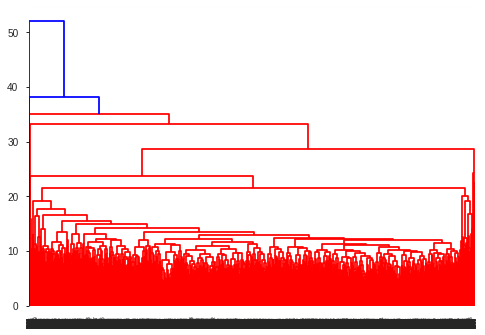

[20.07047768 21.4600823  22.42133815 23.6864358  24.29458355 28.67948582
 33.2937114  35.16077185 38.12665039 52.06930483]


In [447]:
#определим оптимальное количество групп, на которые выборка будет разделена
clusters = linkage(data_clustering.to_numpy(), method = 'complete')
dendrogram(clusters)
plt.show()

#изучим последние строки третьего столбца полученной матрицы (в ней хранятся расстояния между кластерами)
print(clusters[-10: , 2])

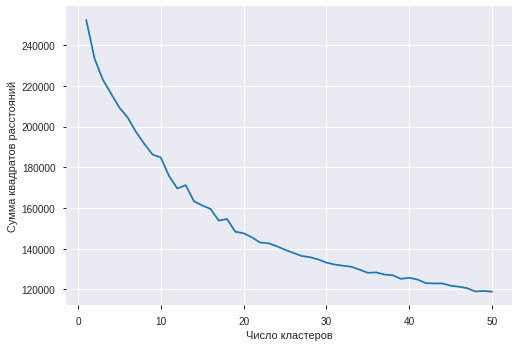

In [535]:
distance = []
for clusters_num in range(1, 51):
    kmeans_fit = KMeans(n_clusters = clusters_num, max_iter = 1000).fit(data_clustering.to_numpy())
    distance.append(kmeans_fit.inertia_) #сумма квадратов расстояний от элементов до их ближайших центров кластеров
    
plt.figure()
plt.plot(range(1, len(distance) + 1), distance)
plt.xlabel("Число кластеров")
plt.ylabel("Сумма квадратов расстояний")
plt.show()

#кластеризация была проведена как для исходных данных, так и для отскалированных
#на исходных данных получилось более адекватно определить число групп
#(данный вывод был сделан исходя из дерева сверху)
#по итогам обоих испытаний оптимальным числом классов будет 10-15. Пускай их будет 13.
#График ниже необходим для правила локтя. Оно, конечно, не является строгим математическим правилом, но
#помогает визуально оценить желаемое количество кластеров

In [541]:
#итоговая разметка обучающей выборки
data_train['ГРУППА'] = KMeans(n_clusters = 13, algorithm = 'full',\
                                   max_iter = 5000).fit(data_clustering.to_numpy()).labels_
data_train.to_excel("Data/data_train_clustered.xlsx")
data_train.head()

ИД    ВОЗРАСТ  ВОЗРАСТ.ЛЕТ  ПОЛ  СМЕНА_МЖ  ЗАГРАН  БРАК  ДЕТИ  ИЖДИВЕНЦЫ  \
0   1  26.936986           27    1         0       0     2     0          0   
1   3  31.742466           32    2         0       0     1     2          2   
2   4  23.172603           23    1         0       0     1     1          1   
3   5  24.424658           24    1         0       0     2     0          0   
4   6  28.654795           29    2         0       0     2     0          0   

   ОБРАЗОВАНИЕ  ...  СУММА_ВЫДАННОГО_КРЕДИТА  ОТДЕЛЕНИЕ  ГОРОД  \
0            2  ...                  60000.0         27     10   
1            2  ...                  50000.0         29     12   
2            2  ...                  30000.0         39      1   
3            2  ...                  70000.0        115      1   
4            2  ...                  15000.0         53      9   

   ЗАПРОШЕННАЯ_СУММА  СОБСТВЕННИК_ФАКТ.  ДОХОД_СУПРУГИ(А)  КРЕДИТЫ_ПОГАШЕНЫ  \
0              60000                  5                 0                 0   
1              50000                  4             12000                 0   
2              30000                  3                 0                 1   
3              70000                  3                 0                 0   
4              15000                  1                 0                 0   

   ПЕРВЫЙ_КРЕДИТ  ДЕФОЛТ60  ГРУППА  
0              0         0       1  
1              1         0       9  
2              0         1       4  
3              0         1       4  
4              0         0       2  

[5 rows x 29 columns]

In [485]:
#посмотрим на распределения признаков в зависимости от таргета
for feature in list(data_train_processed.drop(columns = ['ДЕФОЛТ60']).columns):
    print(feature)
    fig = make_subplots(rows = 1, cols = 2)
    fig.add_trace(go.Histogram(x = data_train_processed[data_train_processed['ДЕФОЛТ60'] == 1][feature],\
                               name = "Не выплатили"), row = 1, col = 1)
    fig.add_trace(go.Histogram(x = data_train_processed[data_train_processed['ДЕФОЛТ60'] == 0][feature],\
                               name = "Выплатили"), row = 1, col = 2)
    #fig = px.histogram(X_test, x = feature)
    #fig.show()
    #fig = px.histogram(X_original, x = feature)
    fig.show()

ПОЛ


ИЖДИВЕНЦЫ


ОБРАЗОВАНИЕ


ИНОСТР.ЯЗЫК


ДОЛЖНОСТЬ


ЗАПРОШЕННАЯ_СУММА


КРЕДИТЫ_ПОГАШЕНЫ


ПЕРВЫЙ_КРЕДИТ


ДОХОД_СУПРУГИ(А)_ФЛАГ


ГОРОД_0


ГОРОД_1


ГОРОД_9


ГОРОД_10


ГОРОД_15


ГОРОД_22


ГОРОД_27


ОТРАСЛЬ_0


ОТРАСЛЬ_1


ОТРАСЛЬ_9


ОТРАСЛЬ_10


ОТРАСЛЬ_15


ОТРАСЛЬ_22


ОТРАСЛЬ_27


РАБОТА_В_ОРГ_1


РАБОТА_В_ОРГ_2


РАБОТА_В_ОРГ_3


РАБОТА_ПО_НАПР_1


РАБОТА_ПО_НАПР_2


РАБОТА_ПО_НАПР_3


СУПРУГ_ПОЛ_ДОХОД


БРАК


ВОЗРАСТ


ДЕТИ


ДОХОД_НА_ОДНОГО_ЧЛЕНА_СЕМЬИ


ДОХОД_СЕМЬИ_


СУММА_ВЫДАННОГО_КРЕДИТА


ПЕРСОНАЛЬНЫЙ_ДОХОД


СОБСТВЕННИК_ФАКТ.


ДОХОД_СУПРУГИ(А)


ЗАПРОС_ВЫДАЛИ_РАЗНИЦА


КРЕДИТ_ЗАРПЛАТА_ОТНОШЕНИЕ


КРЕДИТ_ЗАРПЛАТА_СУПРУГА_ОТНОШЕНИЕ


КРЕДИТ_ДОХОД_ОТНОШЕНИЕ


КРЕДИТ_ДОХОД_1_ОТНОШЕНИЕ


In [494]:
#перейдем к прогнозу дефолта
#для начала изучим PCA
pca = PCA(n_components = data_final_train.shape[1] - 2)
pca.fit(data_final_train.drop(columns = ['ДЕФОЛТ60', 'Weights']).to_numpy())
fig = px.line(x = np.arange(1, data_final_train.shape[1]-1), y = np.cumsum(pca.explained_variance_ratio_),\
        labels={"x": "Количество предикторов", "y": "Доля объяснённой дисперсии"},\
        title = "Доля объяснённой дисперсии в зависимости от количества предикторов")
fig.show()
#как можно видеть, из всех оконачтельных признаков лишь ~70% дают основной вклад

In [524]:
#с помощью базовой модели XGBoost (без настройки каких-либо параметров) изучим feature importance
XGBC = XGBClassifier()
XGBC_Fit = XGBC.fit(data_train_processed.drop(columns = 'ДЕФОЛТ60').to_numpy(),\
                    data_train_processed['ДЕФОЛТ60'].to_numpy())
pred = XGBC_Fit.predict_proba(data_train_processed.drop(columns = 'ДЕФОЛТ60').to_numpy())[:, 1]
print(roc_auc_score(data_train_processed['ДЕФОЛТ60'].to_numpy(), pred))
FeatureImpDF = pd.DataFrame(data = XGBC_Fit.feature_importances_.reshape(1, -1),
                            columns = list(data_train_processed.drop(columns = 'ДЕФОЛТ60').columns))
fig = px.bar(x = list(data_train_processed.drop(columns = 'ДЕФОЛТ60').columns), y = XGBC_Fit.feature_importances_,\
             labels={"x": "Предикторы", "y": "Gain"},\
             title = "Feature Importance")
fig.show()
#fig = px.histogram(x = pred, title = "Predicted prob")
#fig.show()

0.7660387294189419


In [525]:
#исходя из гистограммы сверху, можно убрать часть признаков
remove_features = ["ОТРАСЛЬ_" + str(i) for i in [1,10,15,22,27]] +\
                  ["ИНОСТР.ЯЗЫК", "РАБОТА_В_ОРГ_1", "РАБОТА_В_ОРГ_2",\
                   "РАБОТА_ПО_НАПР_1", "РАБОТА_ПО_НАПР_2", "РАБОТА_ПО_НАПР_3", "КРЕДИТЫ_ПОГАШЕНЫ"] +\
                  ["ГОРОД_" + str(i) for i in [0,1,9,10,22]]

#подготовим данные
X_train = data_final_train.drop(columns = remove_features + ['ДЕФОЛТ60', 'Weights'])
y_train = data_final_train['ДЕФОЛТ60']
Weights = data_final_train['Weights']

X_val = data_final_validate.drop(columns = remove_features + ['ДЕФОЛТ60'])
y_val = data_final_validate['ДЕФОЛТ60']

X_test = data_test_processed.drop(columns = remove_features + ['ДЕФОЛТ60 (Прогноз)', 'Скоринговый балл'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Наилучшие параметры:
 {'booster': 'gbtree', 'colsample_bytree': 0.85, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5.0, 'n_estimators': 55, 'subsample': 0.8}
Best ROC AUC score: 0.6284155135491343
ROC AUC score на out-of-sample данных: 0.6259691697191697


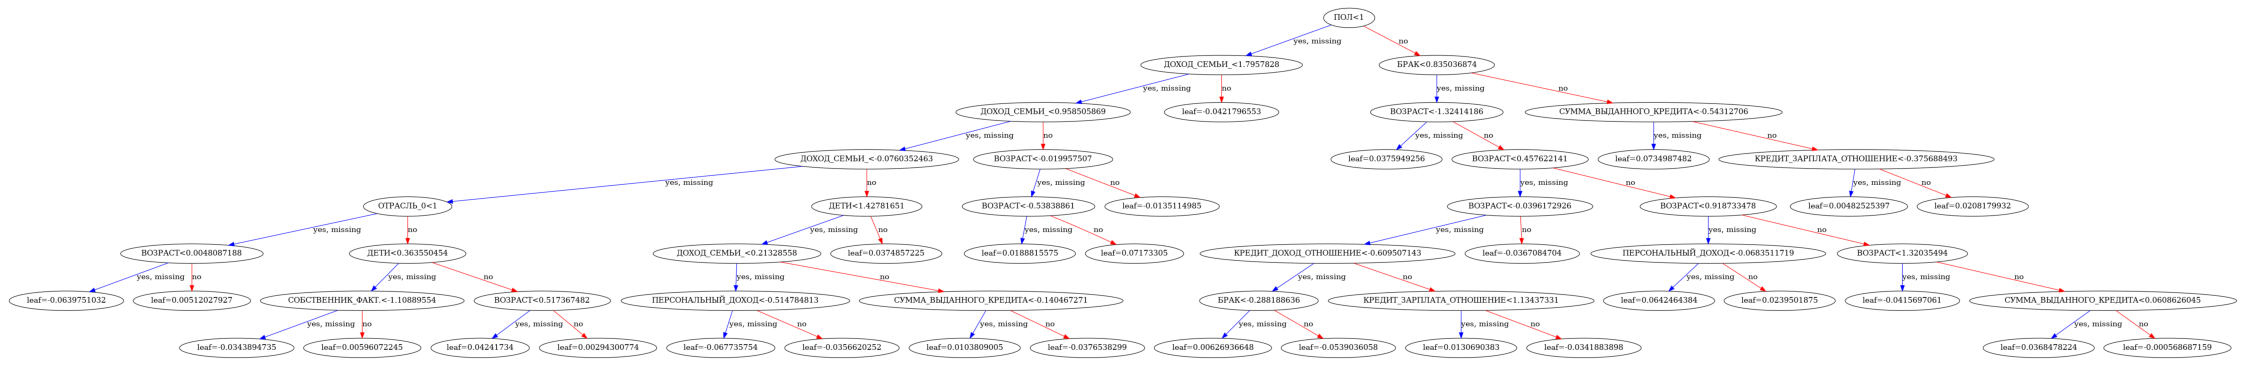

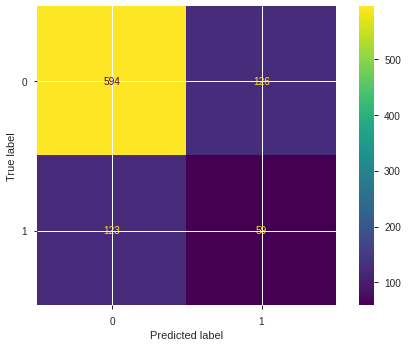

In [526]:
#бустинг
XGBC_base = XGBClassifier(learning_rate = 0.1, verbosity = 1, objectve = 'binary:logistic', n_jobs = -1)
XGB_GS_base = GridSearchCV(
        XGBC_base,
        {
            'n_estimators': [55],
            'learning_rate': [0.1],
            'max_depth': [7],
            'booster': ['gbtree'],
            'min_child_weight': [5.0],
            #'scale_pos_weight': np.linspace(0.9, 1.1, num = 5),
            #'reg_alpha': [0.01],
            #'reg_lambda': [0.01], #np.linspace(0.5, 1.0, num = 5),
            'gamma': [0.0],
            'subsample': [0.8],
            'colsample_bytree': [0.85]
        },
        scoring = 'roc_auc',
        n_jobs = -1,
        cv = 5,
        verbose = 4
)
XGB_GS_base.fit(X_train, y_train, sample_weight = Weights)
print("Наилучшие параметры:\n", XGB_GS_base.best_params_)
print(f"Best ROC AUC score: {XGB_GS_base.best_score_}")
print(f"ROC AUC score на out-of-sample данных: {roc_auc_score(y_val, XGB_GS_base.predict_proba(X_val)[:,1])}")
fig = px.histogram(x = XGB_GS_base.predict_proba(X_val)[:, 1], title = "Predicted prob")
fig.show()
fig, ax = plt.subplots(figsize=(40, 40))
plot_tree(XGB_GS_base.best_estimator_, num_trees = 49, ax=ax)
fig = plt.gcf()
#fig.set_size_inches(30, 30)
plt.show()
plot_confusion_matrix(XGB_GS_base.best_estimator_, X_val, y_val)  
plt.show() 

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Наилучшие параметры:
 {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 150}
Best ROC AUC score: 0.6258419390843718
ROC AUC score на out-of-sample данных: 0.6141941391941392


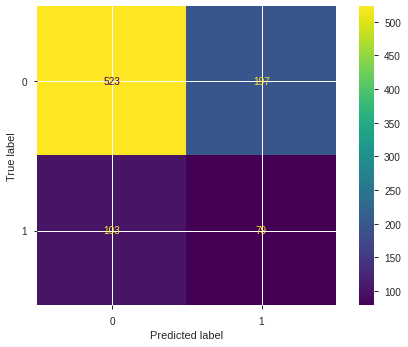

In [527]:
#случайный лес
RFC_base = RandomForestClassifier(max_features = 'auto', n_jobs = -1, class_weight = 'balanced_subsample')
RFC_GS_base = GridSearchCV(
        RFC_base,
        {
            'n_estimators': [150],
            'max_depth': [8],
            'criterion': ['gini', 'entropy']
        },
        scoring = 'roc_auc',
        n_jobs = -1,
        cv = 10,
        verbose = 4
)
RFC_GS_base.fit(X_train, y_train)
print("Наилучшие параметры:\n", RFC_GS_base.best_params_)
print(f"Best ROC AUC score: {RFC_GS_base.best_score_}")
print(f"ROC AUC score на out-of-sample данных: {roc_auc_score(y_val, RFC_GS_base.predict_proba(X_val)[:,1])}")
fig = px.histogram(x = RFC_GS_base.predict_proba(X_val)[:, 1])
fig.show()
plot_confusion_matrix(RFC_GS_base.best_estimator_, X_val, y_val)  
plt.show() 

ROC AUC score на out-of-sample данных: 0.6601037851037852


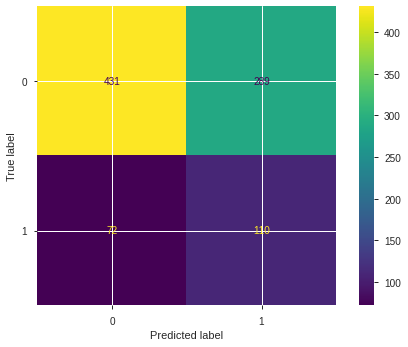

In [528]:
#лог регрессия (некий базовый уровень)
LR = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
LR_fit = LR.fit(X_train, y_train)
print(f"ROC AUC score на out-of-sample данных: {roc_auc_score(y_val, LR_fit.predict_proba(X_val)[:,1])}")
fig = px.histogram(x = LR_fit.predict_proba(X_val)[:, 1])
fig.show()
plot_confusion_matrix(LR_fit, X_val, y_val)  
plt.show() 

In [544]:
#спрогнозируем флаг дефолта и скоринговый балл
#скоринговый балл будет вычисляться как (вероятность дефолта)*(сумма выданного кредита)/(доход семьи)
#в качестве прогнозной модели выбран бустинг, так как он показал наилучшие результаты среди моделей
#по метрике roc auc, confusion matrix и распределению прогнозных вероятностей (чем больше вероятностей
#около 0.5, то больше модель находится в неопределённости)

XGB_final = XGBClassifier(verbosity = 1, objectve = 'binary:logistic', n_jobs = -1,\
                          booster = 'gbtree', colsample_bytree = 0.85, gamma = 0.0, learning_rate = 0.1,\
                          max_depth = 7, min_child_weight = 5.0, n_estimators = 55, subsample = 0.8)

WeightRatioFinal = data_train_processed[data_train_processed['ДЕФОЛТ60'] == 1].shape[0]/\
                   data_train_processed[data_train_processed['ДЕФОЛТ60'] == 0].shape[0]
data_train_processed['Weights'] = WeightRatioFinal
data_train_processed.loc[data_train_processed['ДЕФОЛТ60'] == 1, 'Weights'] = 1 - WeightRatioFinal
X_final = data_train_processed.drop(columns = remove_features + ['ДЕФОЛТ60', 'Weights'])
y_final = data_train_processed['ДЕФОЛТ60']
Weights_final = data_train_processed['Weights']

XGB_final_fit = XGB_final.fit(X_final, y_final, sample_weight = Weights_final)

default_60_flg = XGB_final_fit.predict(X_test)
default_60_prob = XGB_final_fit.predict_proba(X_test)[:, 1]
data_test['ДЕФОЛТ60 (Прогноз)'] = default_60_flg
data_test['Скоринговый балл'] = default_60_prob*\
                                data_test['СУММА_ВЫДАННОГО_КРЕДИТА']/data_test['ДОХОД_СЕМЬИ_']
data_test.to_excel("Data/data_test_predicted.xlsx")